In [1]:
import pickle
import torch
import sys
import os
import numpy as np
from train_utils import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse
from evaluate_network import evaluate
from datasets.argoverse_lane_loader import read_pkl_data
from argoverse.map_representation.map_api import ArgoverseMap
import pandas as pd
sys.path.append('..')


In [2]:
from datasets import helper

import tqdm
import pickle
from collections import defaultdict
from typing import Dict, Optional
from datasets.argoverse_lane_loader import read_pkl_data
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap

In [3]:
#dataset_path = '../../argoverse_data/rose'
dataset_path = '../argoverse_data'
val_path = os.path.join(dataset_path, 'val') #, 'lane_data'
val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)

In [4]:

def get_coverage(pr_pos, gt_pos, pred_m, rho = 0.9):
    sigma = calc_sigma(pred_m)
    contour = - 2 * torch.log(torch.tensor(1.0)-rho)
    det = torch.det(sigma)
    dist =  quadratic_func(gt_pos - pr_pos, sigma.inverse()) / det 
    #print(dist)
    #print(contour)
    cover = torch.where(dist < torch.tensor(contour, device=dist.device), torch.ones(dist.shape, device=dist.device), torch.zeros(dist.shape, device=dist.device))
    return cover    

In [5]:
def construct_df(pos, sig, track_id, agent_id, city):
    obj_type = np.array(['OTHERS'] * len(pos))
    track_id = track_id.squeeze()
    agent_id = agent_id.squeeze()
    #sig = sig.squeeze()
    obj_type[track_id == agent_id] = 'AGENT'
    df = pd.DataFrame(data = {'TRACK_ID': track_id.tolist(), 
                              'X': pos[:,0], 
                              'Y': pos[:,1], 
                              'sig0': sig[:,0,0],
                              'sig1': sig[:,0,1],
                              'sig2': sig[:,1,0],
                              'sig3': sig[:,1,1],
                              'OBJECT_TYPE': obj_type, 
                              'CITY_NAME': city})
    return df

def equi_pred(sample, model_equi):
    device='cpu'
    batch_size = 1
    
    data = process_batch(sample, device)
    sample['lane_mask'] = [np.array([0])] * batch_size
    data['lane'], data['lane_norm'] = torch.zeros(batch_size, 1, 2, device=device), torch.zeros(batch_size, 1, 2, device=device)
    data['lane_mask'] = torch.ones(batch_size, 1, 1, device=device)

    lane = data['lane']
    lane_normals = data['lane_norm']
    agent_id = data['agent_id']
    city = data['city']
    scenes = data['scene_idx'].tolist()

    mask = data['car_mask'][0].numpy().astype(bool).squeeze(-1)

    zeros = torch.zeros(sum(mask), 2, 2)
    prediction0 = construct_df(data['pos_2s'][0][mask,0], zeros.cpu().numpy(), 
                               data['track_id0'][0][mask], data['agent_id'][0], 
                               data['city'][0])
    for i in range(1,18):
        prediction0 = prediction0.append(construct_df(data['pos_2s'][0][mask,i], zeros.cpu().numpy(),
                                                      data['track_id0'][0][mask], data['agent_id'][0], 
                                                      data['city'][0]))
    prediction0 = prediction0.append(construct_df(data['pos0'][0][mask], zeros.cpu().numpy(), 
                                                  data['track_id0'][0][mask], data['agent_id'][0], 
                                                  data['city'][0]))

    inputs = ([
    data['pos_2s'], data['vel_2s'], 
    data['pos0'], data['vel0'], 
    data['accel'], data['sigmas'],
    data['lane'], data['lane_norm'], 
    data['car_mask'], data['lane_mask']
    ])
    m0 = torch.zeros((batch_size, 60, 2, 2), device=device)

    with torch.no_grad():
        pr_pos1, pr_vel1, pr_m1, states = model_equi(inputs)

        prediction0 = prediction0.append(construct_df(pr_pos1.numpy()[0,mask],pr_m1.cpu().numpy()[0,mask], 
                                                      data['track_id0'][0][mask], data['agent_id'][0],
                                                      data['city'][0]))

        pos0, vel0 = data['pos0'], data['vel0']
        for i in range(29):
            pos_enc = torch.unsqueeze(pos0, 2)
            vel_enc = torch.unsqueeze(vel0, 2)
            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'],
                      torch.cat([m0, pr_m1], dim=-2), 
                      data['lane'],
                      data['lane_norm'], data['car_mask'], data['lane_mask'])

            pos0, vel0, m0 = pr_pos1, pr_vel1, pr_m1

            pr_pos1, pr_vel1, pr_m1, states = model_equi(inputs, states)
            prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], pr_m1.cpu().numpy()[0,mask],
                                                          data['track_id0'][0][mask], data['agent_id'][0], 
                                                          data['city'][0]))
            # print('DONE')
    return prediction0

In [39]:
_ZORDER = {"AGENT": 15, "AV": 10, "OTHERS": 5}

def visualize_trajectory(
    df: pd.DataFrame, lane_centerlines = None, show: bool = True, smoothen: bool = False, 
    gt = True
) -> None:

    # Seq data
    # time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]

    lane_centerlines = helper.get_lanes(df, city_name) if lane_centerlines is None else lane_centerlines

    plt.figure(0, figsize=(8, 7))


    x_min = min(df["X"])
    x_max = max(df["X"])
    y_min = min(df["Y"])
    y_max = max(df["Y"])
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "-", color="darkgrey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")

    # plt.xlabel("Map X")
    # plt.ylabel("Map Y")

    color_dict = {"AGENT": "#d33e4c", "OTHERS": "deepskyblue", "AV": "deepskyblue"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]

        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x[:19],
            cor_y[:19],
            "--",
            color=color_dict[object_type],
            label="History",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        plt.plot(
            cor_x[19:],
            cor_y[19:],
            "-",
            color=color_dict[object_type],
            label="Ground Truth" if gt else "Prediction",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        
        pred = prediction_gt[key][0]
        gt = prediction_gt[key][1].numpy()
        cov = get_coverage(pred[:,:2], prediction_gt[key][1], pred[:,-4:].reshape(30,2,2))
        print('cov', cov)

        M = torch.tanh(pred[:,-4:].reshape(30,2,2))
        sigmas = calc_sigma(M).numpy() 

        samples = [np.random.multivariate_normal(gt[i], sigmas[i], size=200) for i in range(len(pred))]
        samples = np.concatenate(samples, axis=0)
        sns.set_style("white")
        # Custom the color, add shade and bandwidth
        sns.kdeplot(data=samples, cmap="Blues", shade=True, thresh=1)

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 5
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 5
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 5

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label='Agent' if object_type == "AGENT" else 'Others',
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )
        

        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")
    #plt.axis("off")
    
    if show:
        plt.show()

In [40]:
prediction_gt.keys()

NameError: name 'prediction_gt' is not defined

In [41]:
def plot_run(sample, model_equi):
    pred = equi_pred(sample, model_equi)

In [42]:
import pickle as pkl

with open('../../argoverse_data/features/val.pkl', "rb") as f:
    features_df: pd.DataFrame = pkl.load(f)

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_id_density(prediction_gt, key, addition=False, shade=False):
  
    pred = prediction_gt[key][0]
    gt = prediction_gt[key][1].numpy()
    cov = get_coverage(pred[:,:2], prediction_gt[key][1], pred[:,-4:].reshape(30,2,2))
    #print('cov', cov)
    
    M = pred[:,-4:].reshape(30,2,2)
    sigmas = calc_sigma(M).numpy() 
    if addition:
        running_sum = 0
        for i,s in enumerate(sigmas):
            sigmas[i] += running_sum 
            running_sum = sigmas[i]


    plt.plot(gt[:,0],gt[:,1], c='deepskyblue')
    plt.plot(pred[:,0],pred[:,1], c='orange')
    plt.plot(gt[-1,0],gt[-1,1], 'o', c='deepskyblue', markersize=5)
    plt.plot(pred[-1,0],pred[-1,1],'o', c='orange', markersize=5)
    sns.set_style("white")

    for i in [0,10,20,29]: #range(len(pred)):
        samples = np.random.multivariate_normal(gt[i], sigmas[i], size=200)
        sns.kdeplot(data=samples, cmap="Blues", shade=shade, alpha=0.5)

    #samples = [np.random.multivariate_normal(gt[i], sigmas[i], size=200) for i in range(len(pred))]
    #samples = np.concatenate(samples, axis=0)
    #sns.kdeplot(data=samples, cmap="Blues", shade=True, thresh=0.01)


    # Custom the color, add shade and bandwidth
    plt.show()


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12014/1824741882.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cover = torch.where(dist < torch.tensor(contour, device=dist.device), torch.ones(dist.shape, device=dist.device), torch.zeros(dist.shape, device=dist.device))


AttributeError: 'Line2D' object has no property 'cmap'

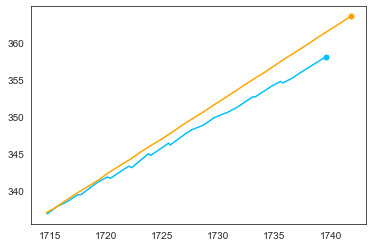

In [45]:
from utils.baseline_config import FEATURE_FORMAT

for k in prediction_gt_dyna.keys():
    plot_id_density(prediction_gt_dyna,k,addition=True)

/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12014/1824741882.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cover = torch.where(dist < torch.tensor(contour, device=dist.device), torch.ones(dist.shape, device=dist.device), torch.zeros(dist.shape, device=dist.device))


AttributeError: 'Line2D' object has no property 'cmap'

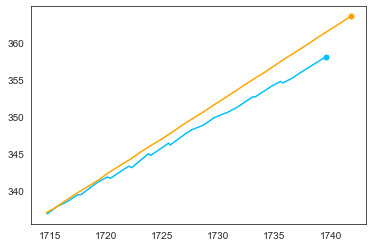

In [47]:
for k in prediction_gt_dyna.keys():
    plot_id_density(prediction_gt_dyna,k)

## Pecco_dynamcis

In [10]:
def nll_dyna(pr_pos, gt_pos, m, car_mask):
    m0, pred_m = m
    sigma = calc_sigma(m0) + calc_sigma(pred_m)

    loss = 0.5 * quadratic_func(gt_pos - pr_pos[...,:2], sigma.inverse()) \
        + torch.log(2 * 3.1416 * torch.pow(sigma.det(), 0.5))
    return torch.mean(loss * car_mask)

In [11]:
from evaluate_dynamics import evaluate

In [49]:
i=0
for valdata in val_dataset:
    testpred = equi_pred(valdata, trained_model_dyna)
    visualize_trajectory(testpred, show=True)
    i += 1
    if i >= 2:
        break

RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [1, 60, 60, 8, 21, 8, 2]->[1, 60, 8, 8, 21, 60, 2] [1, 60, 60, 23, 2]->[1, 60, 1, 1, 23, 60, 2]

In [13]:

val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)

model_name = 'nll_dyna_local' #'rho_reg_pecco'
#trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model_dyna = torch.load('../' + model_name + '.pth',map_location=torch.device('cpu'))

trained_model_dyna.eval()

with torch.no_grad():
    total_loss, prediction_gt_dyna, res = evaluate(trained_model_dyna, val_dataset, nll_dyna,
                                       train_window=30, max_iter=3, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)

evaluating.. 1 2 3 {'loss': array(0.55693614, dtype=float32), 'ADE': 2.4916797, 'ADE_std': 1.2201431, 'coverage': 0.5888889, 'DE@1s': 1.2304822, 'DE@1s_std': 0.50833505, 'DE@2s': 3.5447218, 'DE@2s_std': 1.8278435, 'DE@3s': 5.3616524, 'DE@3s_std': 2.8345373, 'cov@1s': 0.9666667, 'cov@2s': 0.46666667, 'cov@3s': 0.33333334}
done


/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: covariance is not positive-semidefinite.


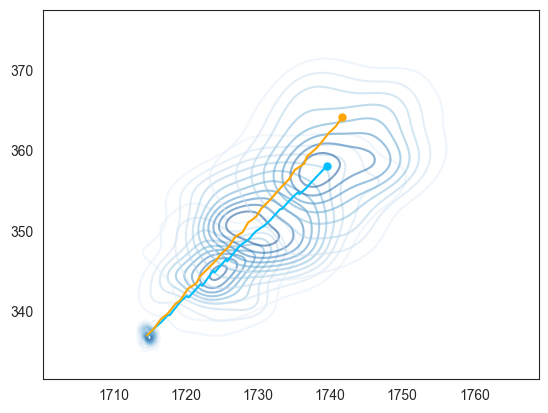

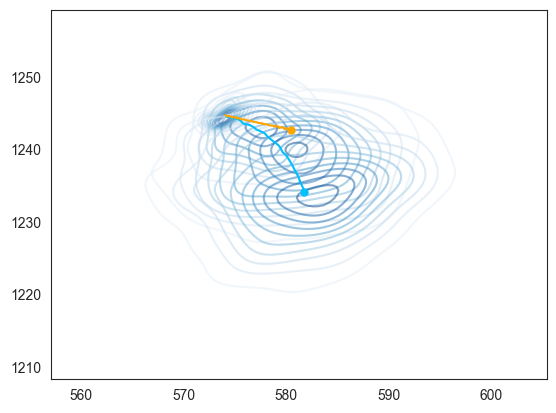

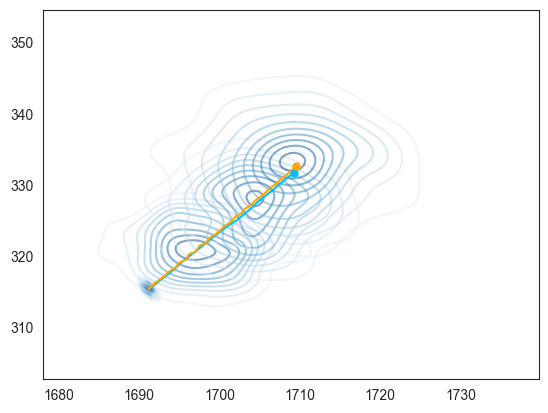

In [411]:
for k in prediction_gt_dyna.keys():
    plot_id_density(prediction_gt_dyna,k,addition=True)

cov tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: covariance is not positive-semidefinite.


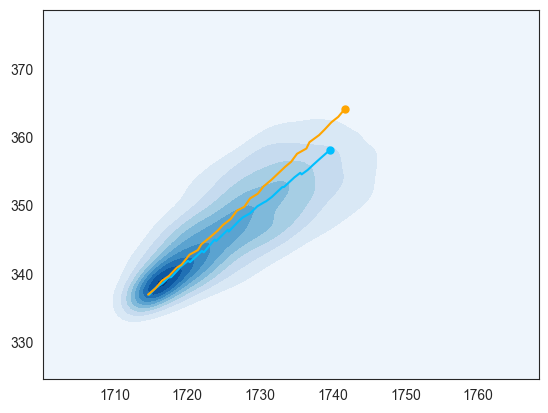

cov tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


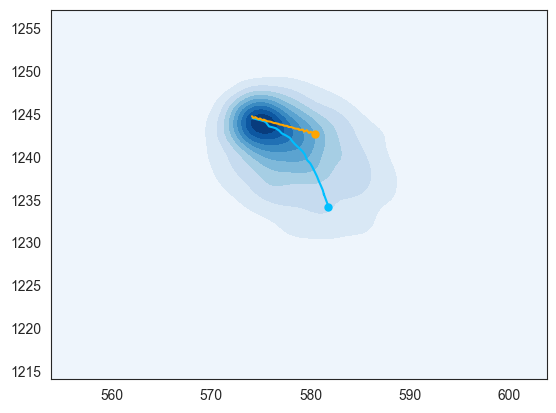

cov tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


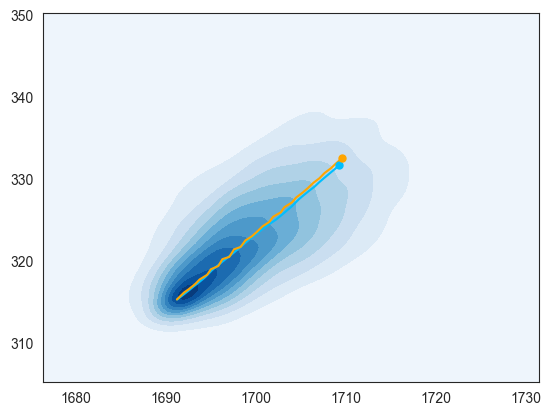

In [378]:
for k in prediction_gt_dyna.keys():
    plot_id_density(prediction_gt_dyna,k,addition=True)

## CstCov

In [320]:
from evaluate_ablation import evaluate
val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)

model_name = 'ablation' #'rho_reg_pecco'
#trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model = torch.load('../' + model_name + '.pth',map_location=torch.device('cpu'))

trained_model.eval()

with torch.no_grad():
    total_loss, prediction_gt = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=10, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)


evaluating.. 1 

KeyboardInterrupt: 

In [ ]:
pred = prediction_gt[10002][0]
gt = prediction_gt[10002][1]
M =  pred[:,3:].reshape(30,2,2)
sigma = calc_sigma(M)
det = torch.det(sigma)
print(sigma)
print(sigma.inverse())

print(det)
cov = get_coverage(pred[:,:2], gt, M)
print('cov', cov)

n = nll(pred[:,:2], gt, M, 1)
print(n)

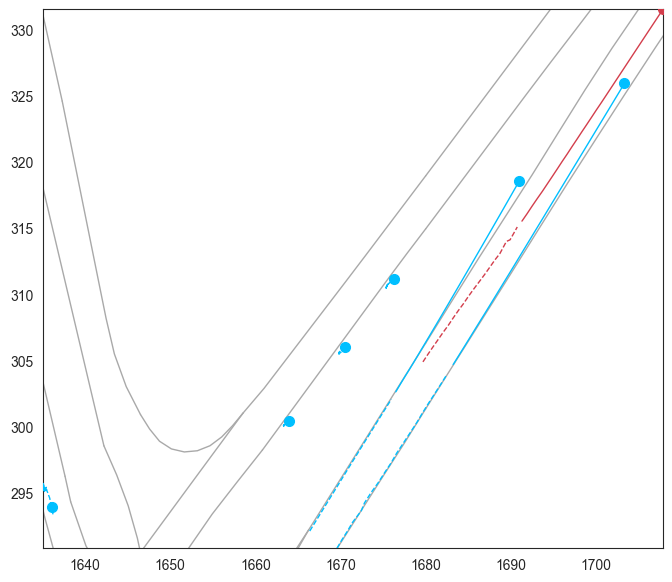

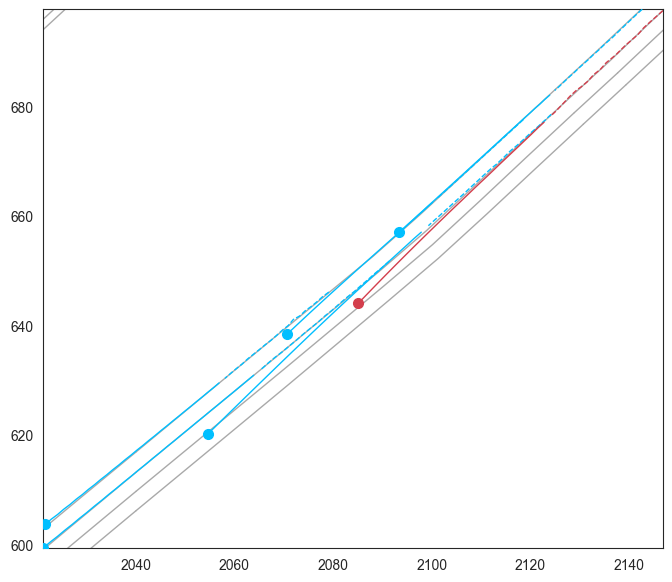

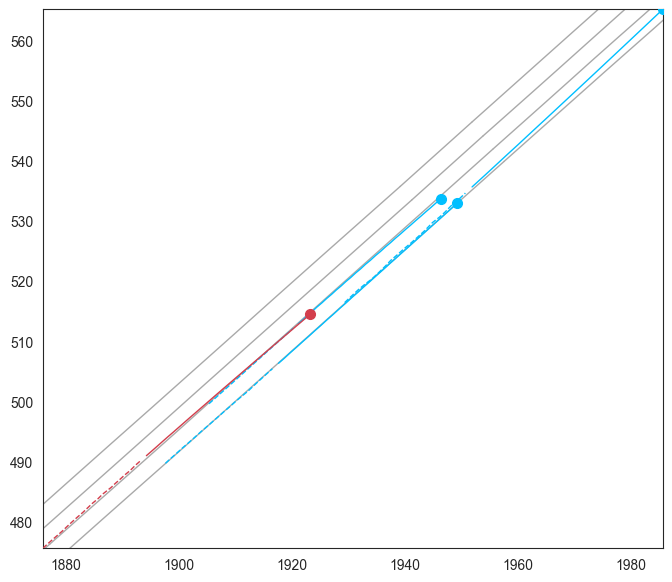

KeyboardInterrupt: 

In [323]:
i=0
for valdata in val_dataset:
    testpred = equi_pred(valdata, trained_model)
    visualize_trajectory(testpred, show=True)
    i += 1
    if i >= 2:
        break

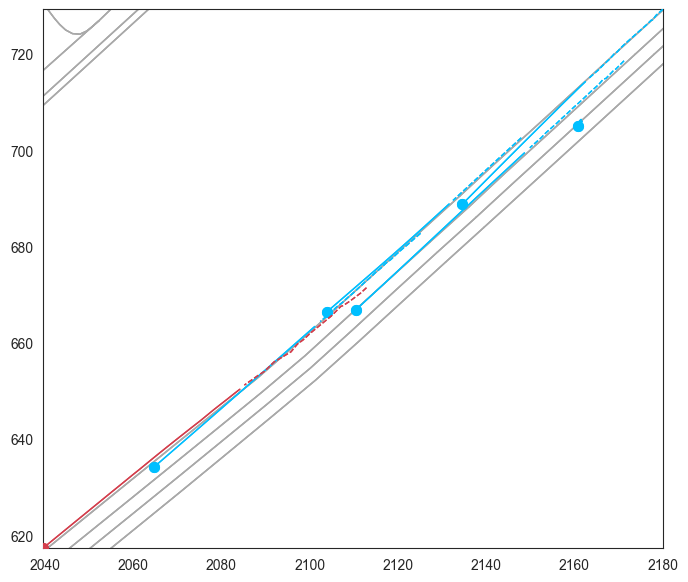

In [296]:
visualize_trajectory(testpred, show=True)

In [330]:
testpred

,TRACK_ID,X,Y,sig0,sig1,sig2,sig3,OBJECT_TYPE,CITY_NAME
0,00000000-0000-0000-0000-000000000000,1905.384277,499.648804,0.000000,0.000000,0.000000,0.000000,OTHERS,PIT
1,00000000-0000-0000-0000-000000080493,1929.392212,516.453308,0.000000,0.000000,0.000000,0.000000,OTHERS,PIT
2,00000000-0000-0000-0000-000000080549,1897.680786,489.751038,0.000000,0.000000,0.000000,0.000000,OTHERS,PIT
3,00000000-0000-0000-0000-000000080560,1875.994019,475.640259,0.000000,0.000000,0.000000,0.000000,AGENT,PIT
0,00000000-0000-0000-0000-000000000000,1906.196655,500.326874,0.000000,0.000000,0.000000,0.000000,OTHERS,PIT
...,...,...,...,...,...,...,...,...,...
3,00000000-0000-0000-0000-000000080560,1922.244507,513.669434,-0.606125,-0.342140,1.758730,-2.005080,AGENT,PIT
0,00000000-0000-0000-0000-000000000000,1946.461060,533.730591,-1.048512,-0.759987,2.408775,-2.543799,OTHERS,PIT
1,00000000-0000-0000-0000-000000080493,1985.687744,565.169434,-0.118352,-0.583852,1.492860,-1.218373,OTHERS,PIT
2,00000000-0000-0000-0000-000000080549,1949.323975,532.956970,-0.568006,-0.560076,2.263973,-2.181700,OTHERS,PIT


In [284]:
testpred

,TRACK_ID,X,Y,sig0,sig1,sig2,sig3,OBJECT_TYPE,CITY_NAME
0,00000000-0000-0000-0000-000000000000,2147.950928,702.631104,0,0,0,0,OTHERS,PIT
1,00000000-0000-0000-0000-000000065495,2112.869629,671.466858,0,0,0,0,AGENT,PIT
2,00000000-0000-0000-0000-000000065852,2125.130859,682.772278,0,0,0,0,OTHERS,PIT
3,00000000-0000-0000-0000-000000066034,2180.039551,729.323181,0,0,0,0,OTHERS,PIT
4,00000000-0000-0000-0000-000000066038,2171.243896,718.621948,0,0,0,0,OTHERS,PIT
...,...,...,...,...,...,...,...,...,...
1,00000000-0000-0000-0000-000000065495,2039.539062,617.338379,"(tensor(-0.0002), tensor(0.0088))","(tensor(-0.0298), tensor(-0.0016))","(tensor(-0.0109), tensor(0.0077))","(tensor(-0.0531), tensor(-0.0266))",AGENT,PIT
2,00000000-0000-0000-0000-000000065852,2064.719727,634.213806,"(tensor(-0.0002), tensor(0.0088))","(tensor(-0.0298), tensor(-0.0016))","(tensor(-0.0109), tensor(0.0077))","(tensor(-0.0531), tensor(-0.0266))",OTHERS,PIT
3,00000000-0000-0000-0000-000000066034,2134.557861,688.796570,"(tensor(-0.0002), tensor(0.0088))","(tensor(-0.0298), tensor(-0.0016))","(tensor(-0.0109), tensor(0.0077))","(tensor(-0.0531), tensor(-0.0266))",OTHERS,PIT
4,00000000-0000-0000-0000-000000066038,2110.539062,666.938904,"(tensor(-0.0002), tensor(0.0088))","(tensor(-0.0298), tensor(-0.0016))","(tensor(-0.0109), tensor(0.0077))","(tensor(-0.0531), tensor(-0.0266))",OTHERS,PIT


tensor([2.1663e+01, 1.4422e+01, 4.1246e+01, 6.2080e+01, 5.1791e+02, 1.4403e+02,
        2.3826e+02, 1.1239e+03, 8.0414e+02, 2.2644e+03, 1.0710e+03, 2.6834e+03,
        2.0188e+03, 4.2406e+03, 3.0497e+03, 3.6894e+03, 5.2401e+03, 5.1583e+03,
        6.7146e+03, 8.7942e+03, 1.0147e+04, 9.2716e+03, 1.2123e+04, 1.1357e+04,
        1.2779e+04, 1.8050e+04, 2.0027e+04, 2.0716e+04, 2.1842e+04, 2.1178e+04])
tensor(4.6052)
cov tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


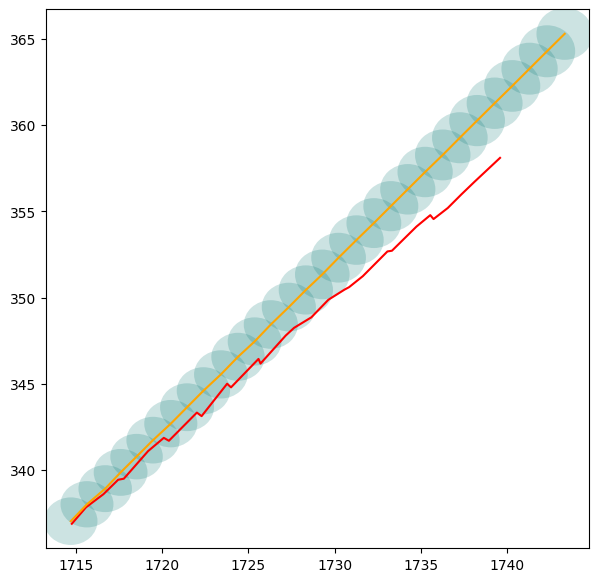

tensor([1.1123e+01, 4.9531e+01, 9.3137e+01, 1.7821e+02, 1.9160e+02, 4.1212e+02,
        5.4456e+02, 6.0416e+02, 9.2403e+02, 1.2071e+03, 1.6100e+03, 2.1750e+03,
        2.5289e+03, 3.2395e+03, 4.3831e+03, 5.3227e+03, 6.0440e+03, 7.8811e+03,
        8.9696e+03, 1.0173e+04, 1.1492e+04, 1.3727e+04, 1.5716e+04, 1.7408e+04,
        1.9746e+04, 2.1795e+04, 2.0022e+04, 2.5666e+04, 2.8033e+04, 2.5975e+04])
tensor(4.6052)
cov tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


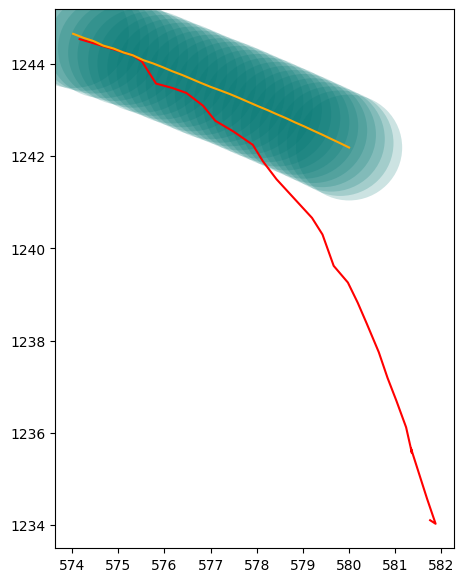

tensor([  87.0147,   70.8896,   89.4979,  125.4828,  166.8865,  184.4520,
          84.4298,  122.7079,  146.8928,  193.1013,  262.1176,  271.5512,
         201.6053,  371.0221,  459.7844,  575.0588,  727.2879,  982.5342,
        1346.3381, 1558.5929, 1278.6793,  999.7384, 1146.7485, 1331.2858,
        1557.4524, 1660.1223, 1844.0743, 2041.8146, 2195.3115, 2436.1489])
tensor(4.6052)
cov tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


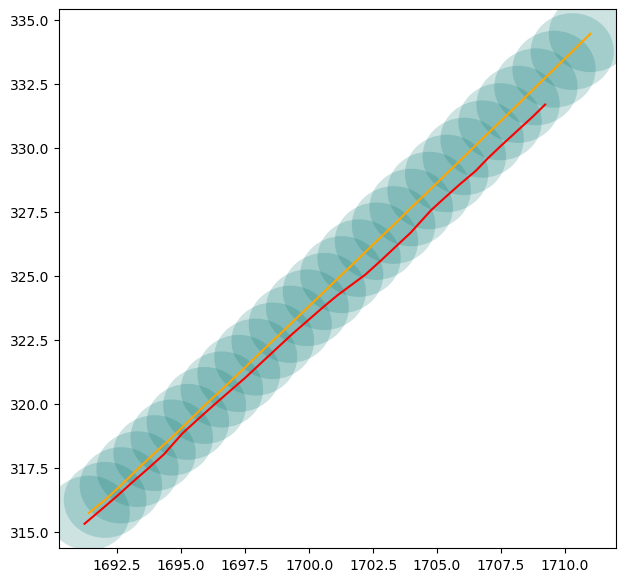

tensor([  31.3615,   57.0645,  143.8829,  409.7609,   81.6597,  167.2923,
         263.7933,  252.3549,  392.0121,  247.1898,  438.1266,  577.1790,
         620.7566,  755.0547,  923.9182, 1056.8365, 1197.3785, 1375.1616,
        1515.9908, 1655.2654, 1981.7094, 2147.3074, 2346.5945, 2764.0044,
        3144.8870, 3537.5068, 3936.4497, 4102.6318, 4474.5884, 5051.1665])
tensor(4.6052)
cov tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


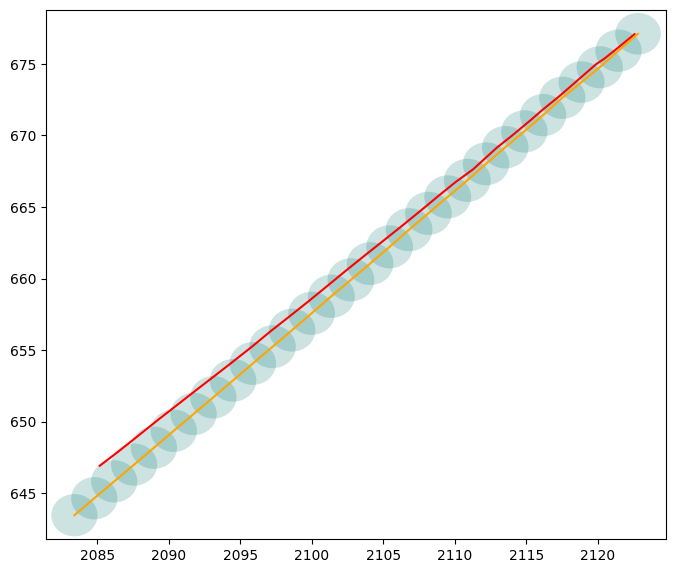

tensor([  7.1710,  15.4133,  97.9930, 112.5280,  55.5074,  12.9365,  57.7775,
         46.7268,  65.4700,  62.5476,  63.9123,  64.0006, 152.7101,  71.9234,
        149.2286, 190.7620, 162.5024, 189.9165, 176.5487, 306.1974, 230.9027,
        246.3967, 406.4771, 469.1519, 381.9407, 453.0455, 570.7836, 707.2150,
        510.0754, 542.9327])
tensor(4.6052)
cov tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


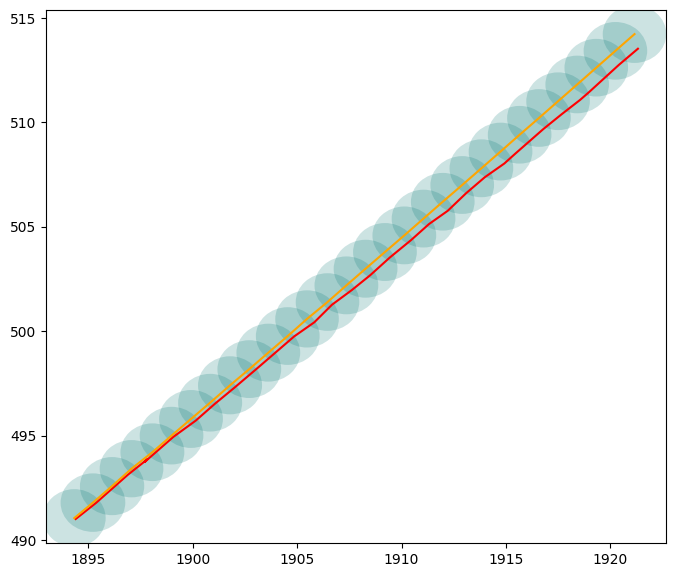

tensor([3.3702e-01, 1.5984e+00, 4.0669e+01, 2.2793e+01, 3.9573e+01, 6.7660e+01,
        1.2863e+02, 2.1883e+02, 3.1888e+02, 4.1668e+02, 5.6307e+02, 7.9872e+02,
        1.0249e+03, 1.2047e+03, 1.5699e+03, 2.0353e+03, 2.5491e+03, 3.3752e+03,
        3.8200e+03, 5.3891e+03, 6.5397e+03, 8.3833e+03, 1.0124e+04, 1.2447e+04,
        1.4270e+04, 1.5855e+04, 1.8347e+04, 2.1557e+04, 2.2780e+04, 2.5077e+04])
tensor(4.6052)
cov tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


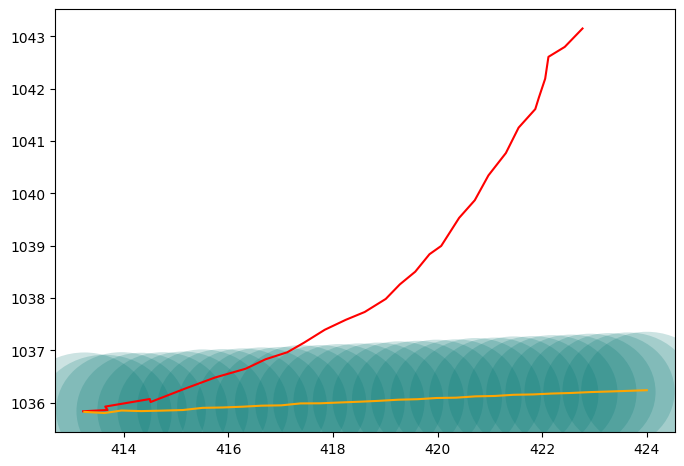

tensor([3.2961e+00, 1.4179e+02, 3.0654e+01, 2.9463e+00, 7.2925e+01, 1.2115e+02,
        1.8215e+02, 2.1251e+02, 1.0612e+03, 1.3595e+03, 1.0682e+03, 4.6078e+02,
        2.1944e+02, 5.1813e+03, 4.9456e+03, 3.8557e+03, 2.1520e+03, 3.5321e+03,
        2.7954e+03, 2.8572e+03, 4.5213e+03, 4.3496e+03, 3.9513e+03, 3.7427e+03,
        3.4942e+03, 1.6877e+04, 1.4138e+04, 1.1146e+04, 9.3722e+03, 1.3175e+04])
tensor(4.6052)
cov tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


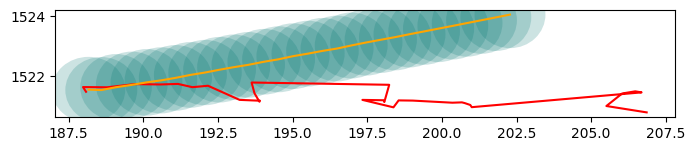

tensor([2.6188e+00, 7.6062e+01, 2.5024e+01, 2.1948e+01, 1.3782e+02, 2.3094e+02,
        3.1340e+02, 3.5473e+02, 4.7041e+02, 2.9912e+02, 4.8495e+02, 1.0299e+03,
        1.0735e+03, 1.1409e+03, 9.4026e+02, 1.7491e+03, 2.2926e+03, 2.2397e+03,
        3.2795e+03, 3.2179e+03, 4.1732e+03, 4.7539e+03, 4.9055e+03, 6.1326e+03,
        5.9176e+03, 7.7847e+03, 7.5956e+03, 8.7657e+03, 9.7203e+03, 1.0854e+04])
tensor(4.6052)
cov tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


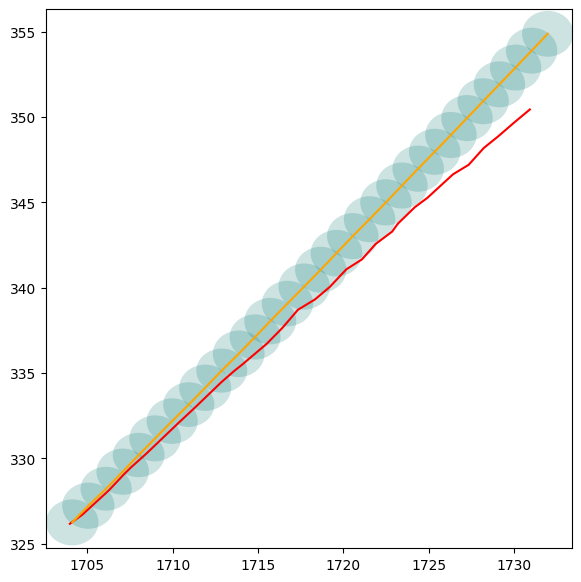

tensor([ 12.7673,  53.2557,   1.7247,  52.2227,  19.2761,   7.0751,  22.5675,
          6.1075,  66.7292,  10.9534,  65.5227, 186.8075, 145.7036, 196.0003,
         41.1892,  99.5580,  57.8338,  70.2172,   8.7628,   5.3285,   4.4214,
         14.5149,  17.9650,  26.2096,  42.8090,  65.3983,  90.5218, 136.9892,
        193.9043, 249.7265])
tensor(4.6052)
cov tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


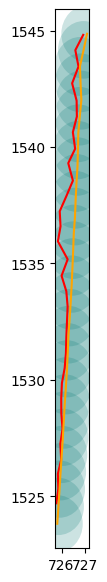

tensor([   8.9740,   11.5661,    9.4734,   46.6104,   37.1874,   89.7989,
          84.4832,   94.1849,   61.6547,   16.0919,   17.6842,   86.4388,
         161.3980,  274.0606,  374.1812,  265.3490,  483.2252,  514.6300,
         727.1100,  628.7092,  762.4874,  626.6155,  601.1145,  674.6891,
         658.8657,  724.8773, 1047.8923,  620.3354,  305.0516,  113.7250])
tensor(4.6052)
cov tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


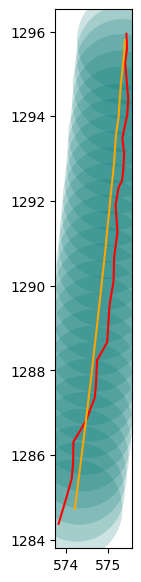

In [25]:
for k in prediction_gt.keys():
    plot_id(k)

# Lane nll

In [322]:
from evaluate_network import evaluate

model_name = 'lane_nll' #'rho_reg_pecco'
#trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model = torch.load('../' + model_name + '.pth',map_location=torch.device('cpu'))

trained_model.eval()


ECCONetwork(
  (conv_fluid): EquiCtsConv2dRho1ToReg()
  (conv_obstacle): EquiCtsConv2dRho1ToReg()
  (dense_fluid): Sequential(
    (0): EquiLinearRho1ToReg()
    (1): EquiLinearRegToReg()
  )
  (convs): ModuleList(
    (0): EquiCtsConv2dRegToReg()
    (1): EquiCtsConv2dRegToReg()
    (2): EquiCtsConv2dRegToReg()
    (3): EquiCtsConv2dRegToRho1()
  )
  (denses): ModuleList(
    (0): EquiLinearRegToReg()
    (1): EquiLinearRegToReg()
    (2): EquiLinearRegToReg()
    (3): Sequential(
      (0): EquiLinearRegToReg()
      (1): EquiLinearRegToRho1()
    )
  )
)

In [36]:

with torch.no_grad():
    total_loss, prediction_gt_equi = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=3, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)


evaluating.. 1 2 3 {'loss': array(0.84683937, dtype=float32), 'ADE': 1.4097372, 'ADE_std': 0.7637908, 'coverage': 0.78888893, 'DE@1s': 0.7157094, 'DE@1s_std': 0.319898, 'DE@2s': 1.9015957, 'DE@2s_std': 0.92752206, 'DE@3s': 2.994212, 'DE@3s_std': 2.3049598, 'cov@1s': 0.90000004, 'cov@2s': 0.8333333, 'cov@3s': 0.6333333}
done


In [39]:
prediction_gt_equi.keys()

dict_keys([10165, 10189, 10196])

In [43]:
pred = prediction_gt_equi[10165][0]
gt = prediction_gt_equi[10165][1]
M =  pred[:,2:].reshape(30,2,2)
sigma = calc_sigma(M)
det = torch.det(sigma)
print(sigma)
print(sigma.inverse())
print(det)
cov = get_coverage(pred[:,:2], gt, M)
print('cov', cov)

n = nll(pred[:,:2], gt, M, 1)
print(n)

tensor([[[ 0.8257, -0.0612],
         [-0.0612,  1.0493]],

        [[ 0.8393, -0.1366],
         [-0.1366,  0.8429]],

        [[ 0.8597, -0.1046],
         [-0.1046,  0.8954]],

        [[ 0.9261, -0.0680],
         [-0.0680,  0.9415]],

        [[ 0.9112, -0.0718],
         [-0.0718,  0.9264]],

        [[ 0.9570, -0.0459],
         [-0.0459,  0.9657]],

        [[ 0.9244, -0.0606],
         [-0.0606,  0.9354]],

        [[ 0.9764, -0.0325],
         [-0.0325,  0.9448]],

        [[ 0.9890, -0.0318],
         [-0.0318,  0.9895]],

        [[ 0.9551, -0.0476],
         [-0.0476,  0.9347]],

        [[ 0.9884, -0.0248],
         [-0.0248,  0.9796]],

        [[ 0.9647, -0.0376],
         [-0.0376,  0.9532]],

        [[ 0.9929, -0.0206],
         [-0.0206,  0.9628]],

        [[ 0.9931, -0.0208],
         [-0.0208,  0.9660]],

        [[ 0.9910, -0.0223],
         [-0.0223,  0.9501]],

        [[ 0.9844, -0.0279],
         [-0.0279,  0.9649]],

        [[ 0.9592, -0.0433],
         [-

/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


cov tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])


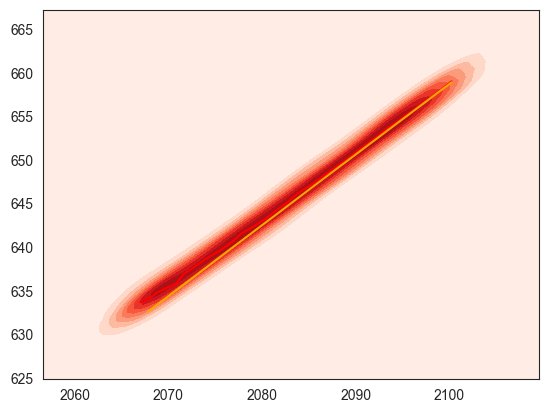

cov tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not positive-semidefinite.


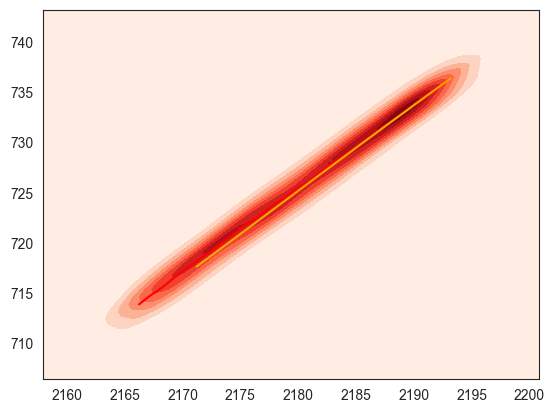

cov tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


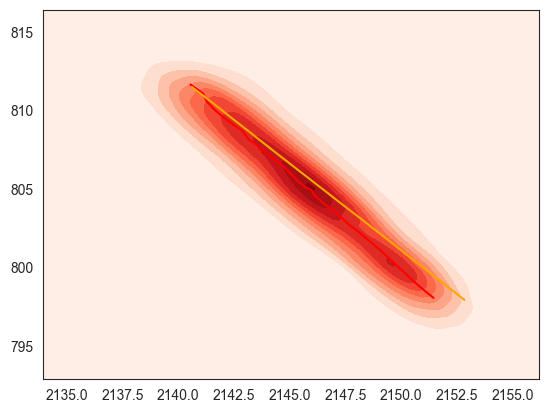

In [271]:
for k in prediction_gt_equi.keys():
    plot_id_density(prediction_gt_equi, k)

In [141]:
from evaluate_network import evaluate

val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)

model_name = 'lane_nll' #'rho_reg_pecco'
#trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model = torch.load('../' + model_name + '.pth',map_location=torch.device('cpu'))

trained_model.eval()

with torch.no_grad():
    total_loss, prediction_gt_equi = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=3, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)


evaluating.. 1 2 3 4 5 6 7 8 9 10 {'loss': array(5.3574386, dtype=float32), 'ADE': 1.9016087, 'ADE_std': 1.1938996, 'DE@1s': 0.92671096, 'DE@1s_std': 0.60409886, 'DE@2s': 2.6160583, 'DE@2s_std': 1.7196554, 'DE@3s': 4.151469, 'DE@3s_std': 2.8607779}
done


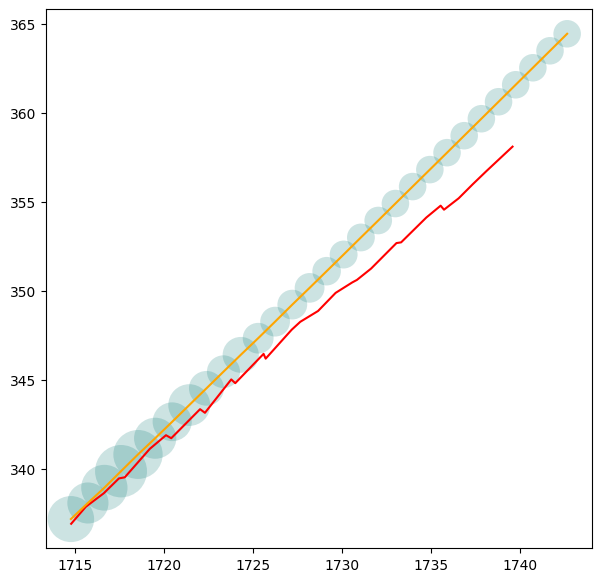

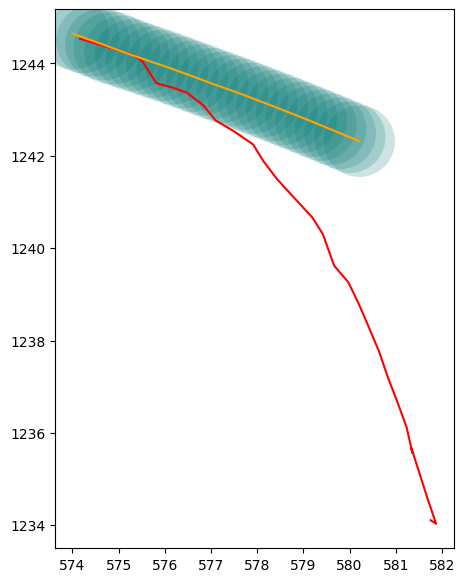

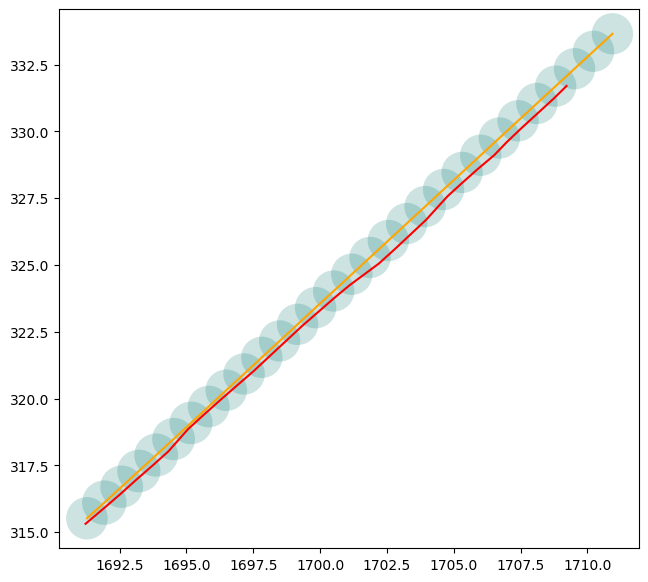

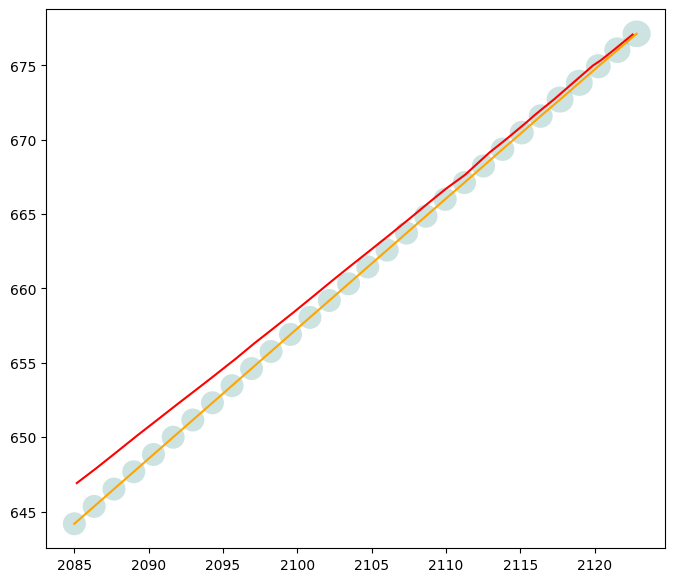

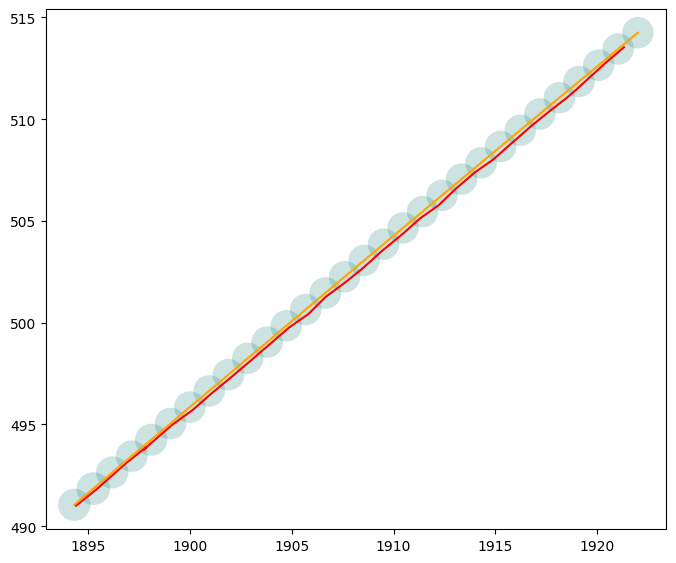

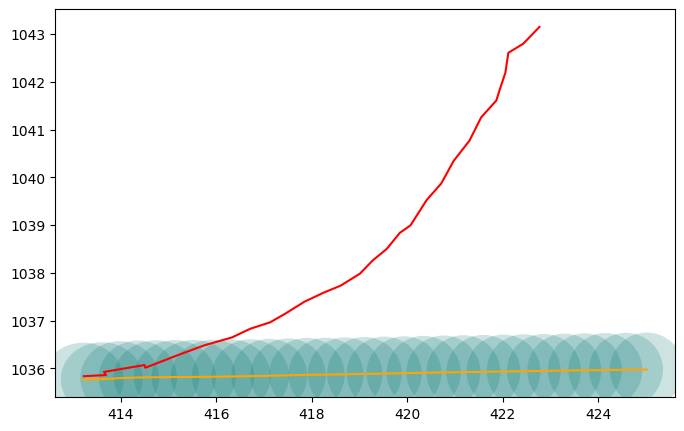

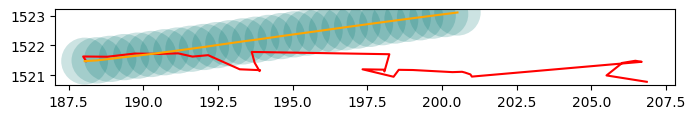

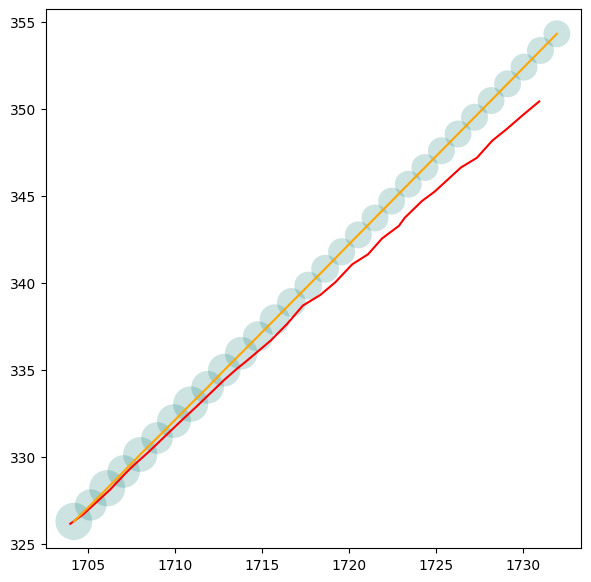

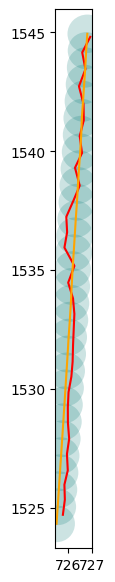

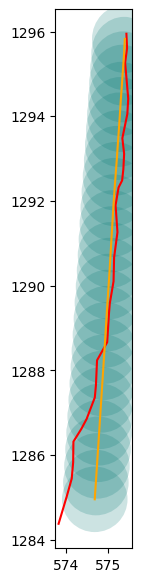

In [142]:
for k in prediction_gt.keys():
    plot_id(k)

# MIS

In [136]:
model_name = 'mis_nautilus' #'rho_reg_pecco'
#trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model = torch.load('../' + model_name + '.pth',map_location=torch.device('cpu'))

trained_model.eval()

with torch.no_grad():
    total_loss, prediction_gt = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=5, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)


evaluating.. 1 2 3 4 5 {'loss': array(4.080206, dtype=float32), 'ADE': 2.5126796, 'ADE_std': 1.4597219, 'DE@1s': 1.3209366, 'DE@1s_std': 0.9028418, 'DE@2s': 3.4727554, 'DE@2s_std': 2.0936458, 'DE@3s': 6.2036247, 'DE@3s_std': 3.2848547}
done


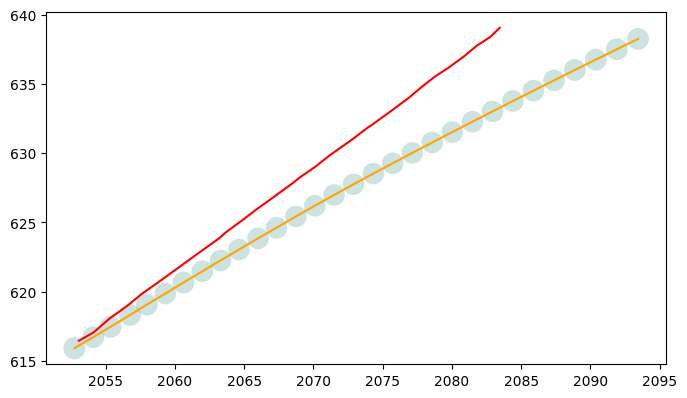

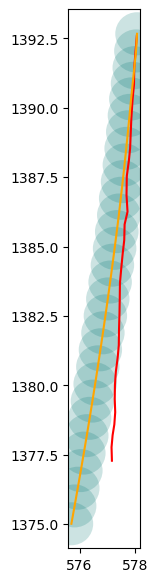

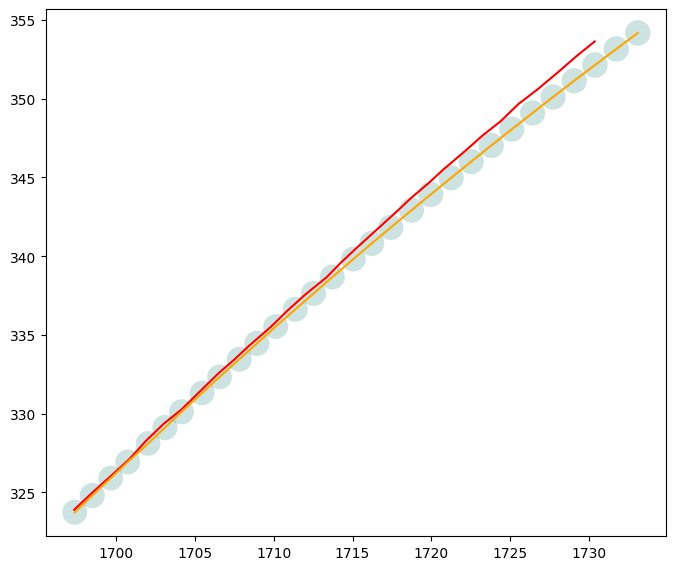

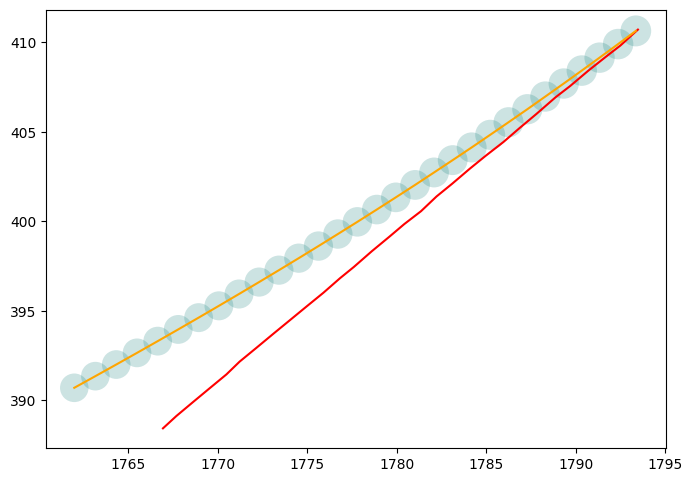

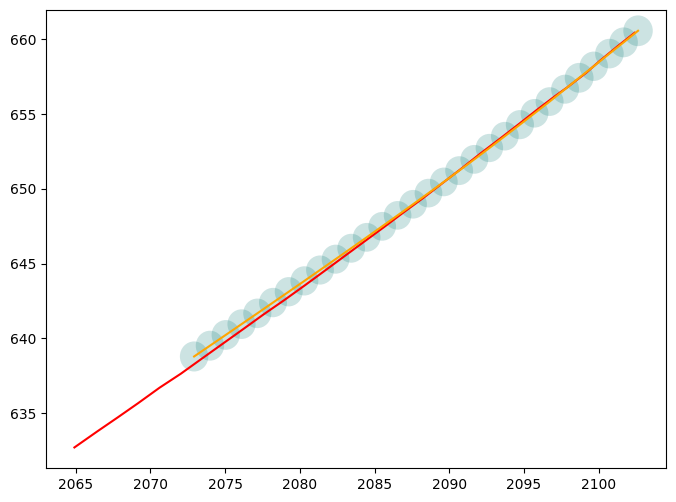

In [140]:
for k in prediction_gt.keys():
    plot_id(k)

# Vanila nll

In [3]:
model_name = 'nll_nautilus' #'rho_reg_pecco'
#trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model = torch.load('../' + model_name + '.pth',map_location=torch.device('cpu'))

trained_model.eval()

ECCONetwork(
  (conv_fluid): EquiCtsConv2dRho1ToReg()
  (conv_obstacle): EquiCtsConv2dRho1ToReg()
  (dense_fluid): Sequential(
    (0): EquiLinearRho1ToReg()
    (1): EquiLinearRegToReg()
  )
  (convs): ModuleList(
    (0): EquiCtsConv2dRegToReg()
    (1): EquiCtsConv2dRegToReg()
    (2): EquiCtsConv2dRegToReg()
    (3): EquiCtsConv2dRegToRho1()
  )
  (denses): ModuleList(
    (0): EquiLinearRegToReg()
    (1): EquiLinearRegToReg()
    (2): EquiLinearRegToReg()
    (3): Sequential(
      (0): EquiLinearRegToReg()
      (1): EquiLinearRegToRho1()
    )
  )
)

In [121]:
with torch.no_grad():
    total_loss, prediction_gt = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=15, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)

evaluating.. 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 {'loss': array(1.7892792, dtype=float32), 'ADE': 2.0755856, 'ADE_std': 1.0687166, 'DE@1s': 1.0388643, 'DE@1s_std': 0.62259406, 'DE@2s': 2.719642, 'DE@2s_std': 1.5643474, 'DE@3s': 5.2632465, 'DE@3s_std': 3.2188854}
done


evaluating.. 1 2 3 4 5 {'loss': array(0.56119573, dtype=float32), 'ADE': 2.7359014, 'ADE_std': 0.9607195, 'DE@1s': 1.4433355, 'DE@1s_std': 0.8767108, 'DE@2s': 3.6503205, 'DE@2s_std': 1.4849739, 'DE@3s': 6.8842173, 'DE@3s_std': 1.8462336}
done


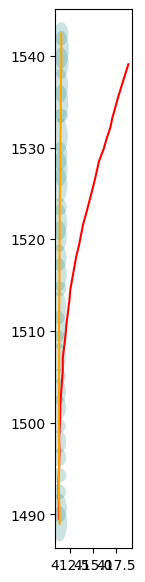

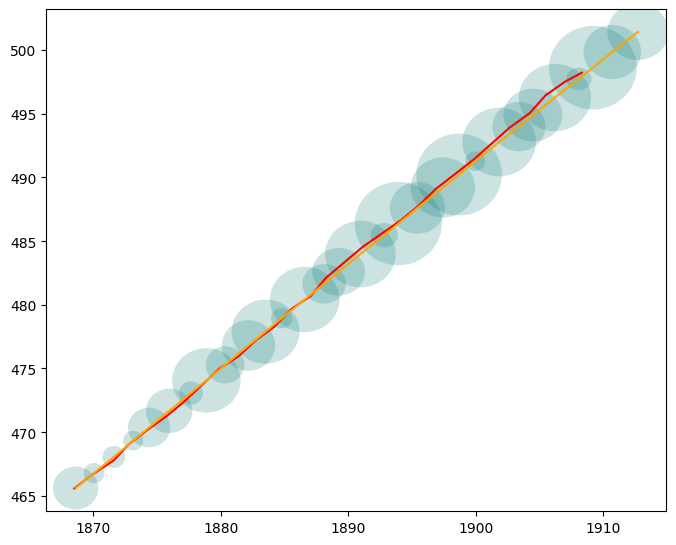

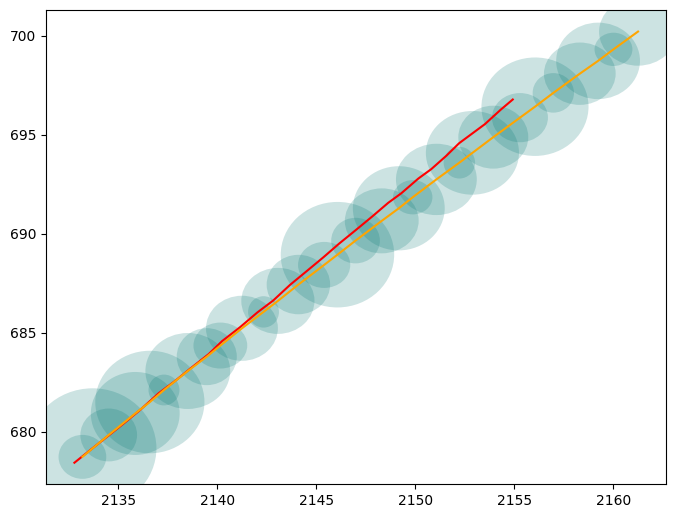

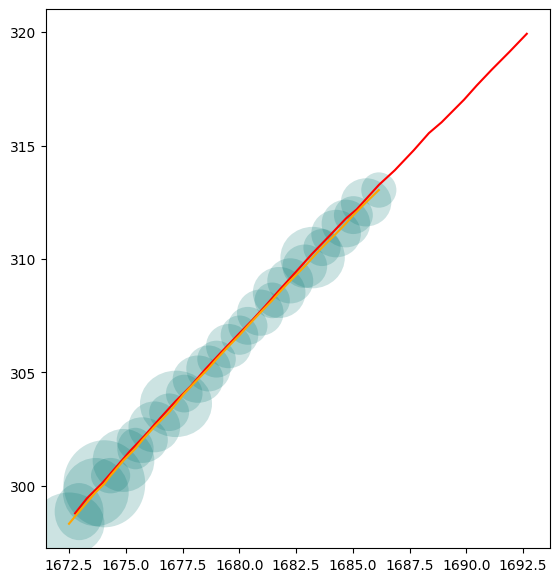

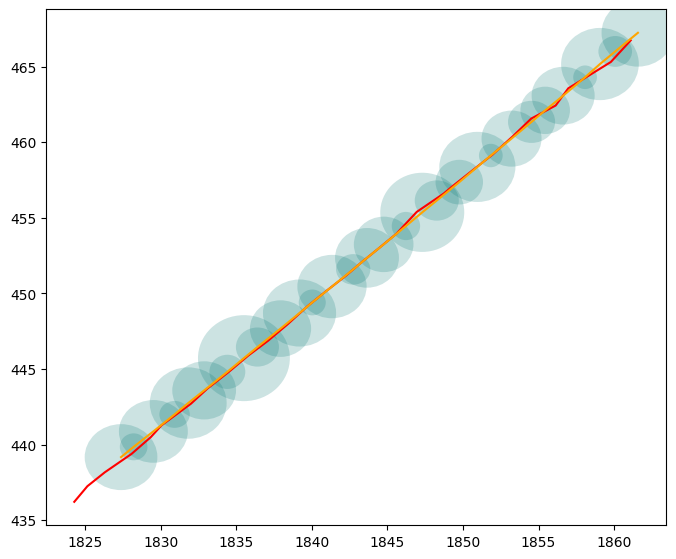

In [124]:
with torch.no_grad():
    total_loss, prediction_gt = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=5, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)
for k in prediction_gt.keys():
    plot_id(k)

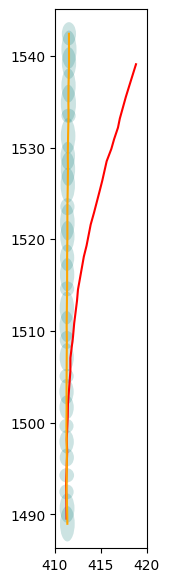

In [133]:
for k in prediction_gt.keys():
    plot_id(k)
    break

evaluating.. 1 2 3 4 5 {'loss': array(5.867696, dtype=float32), 'ADE': 1.779514, 'ADE_std': 0.5546207, 'DE@1s': 1.0566074, 'DE@1s_std': 0.4789157, 'DE@2s': 2.3936296, 'DE@2s_std': 0.76408654, 'DE@3s': 4.098844, 'DE@3s_std': 1.1131274}
done


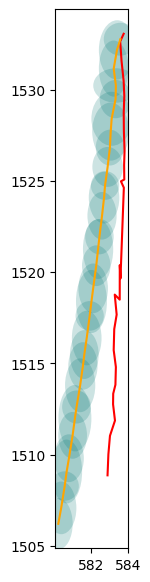

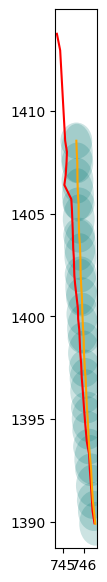

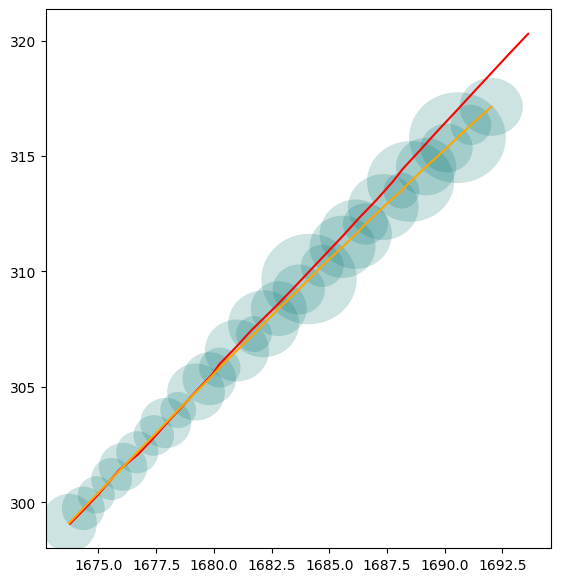

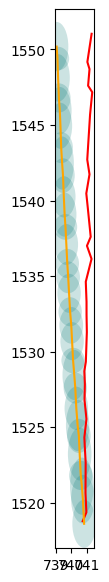

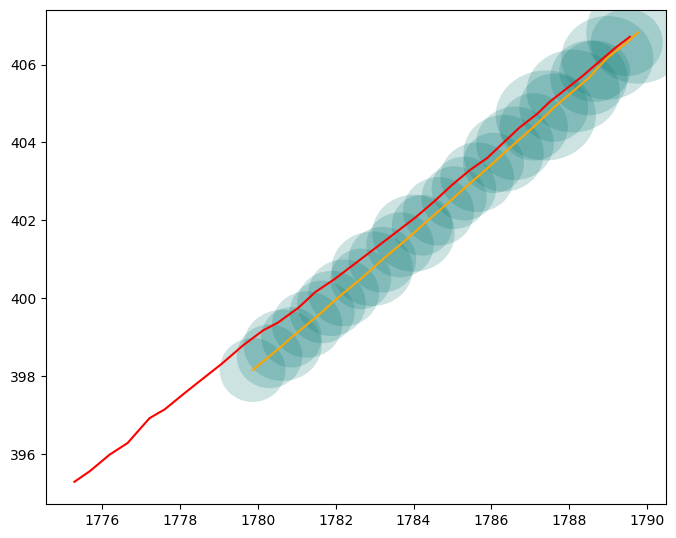

In [123]:
with torch.no_grad():
    total_loss, prediction_gt = evaluate(trained_model, val_dataset, nll,
                                       train_window=30, max_iter=5, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)
for k in prediction_gt.keys():
    plot_id(k)

In [139]:
def plot_id(key):
    pred = prediction_gt[key][0]
    gt = prediction_gt[key][1].numpy()

    M1 = torch.tanh(pred[:,2:].reshape(30,2,2))
    sigma = torch.einsum('...xy,...xz->...yz', M1, M1)
    new_M = 0.1*torch.matrix_exp(sigma)
    pred = pred.numpy()
    new_M = new_M.numpy() 

    sig_x = np.sqrt(new_M[:,0,0])
    sig_y = np.sqrt(new_M[:,1,1])
    rho = new_M[:,0,1]/(sig_x*sig_y)

    fig = plt.figure(0, figsize=(8, 7))

    ax = fig.add_subplot(111, aspect='equal')

    plt.plot(gt[:,0],gt[:,1], c='r')
    plt.plot(pred[:,0],pred[:,1], c='orange')

    scale = 2*np.sqrt(5.991)
    ells = [Ellipse(xy=gaussian[:2], 
                    width=scale*sig_x[i], 
                    height=scale*sig_y[i], 
                    angle=np.arctan(rho[i]))
            for i, gaussian in enumerate(pred)]
    #plt.xlim(410, 420)
    for e in ells:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.2)
        e.set_facecolor("#007672")

    plt.show()

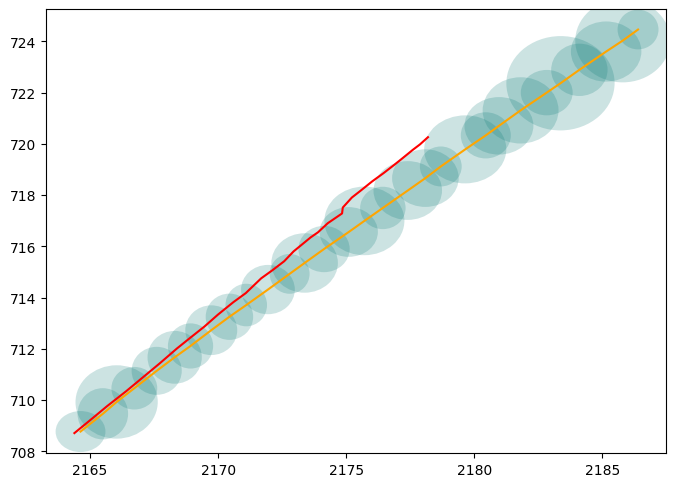

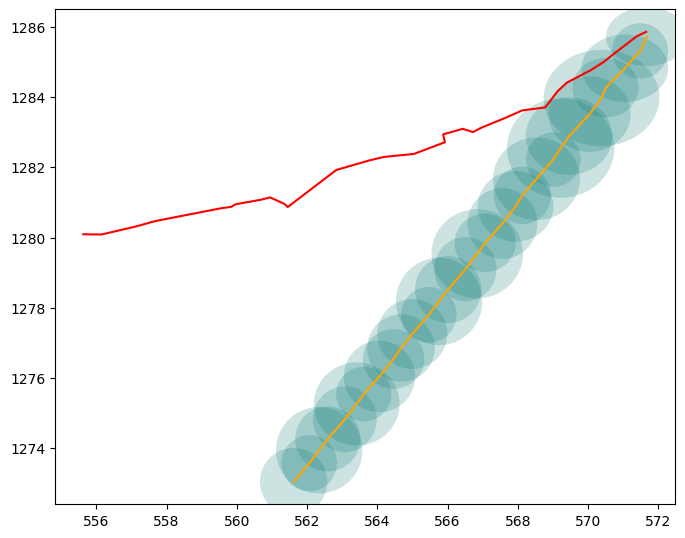

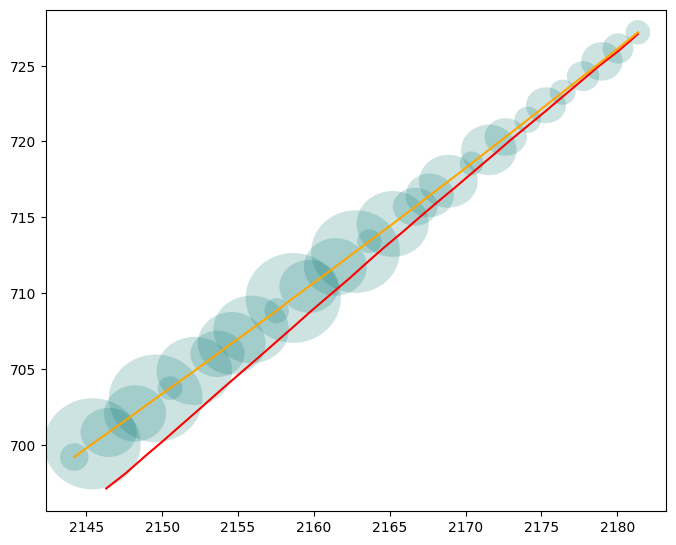

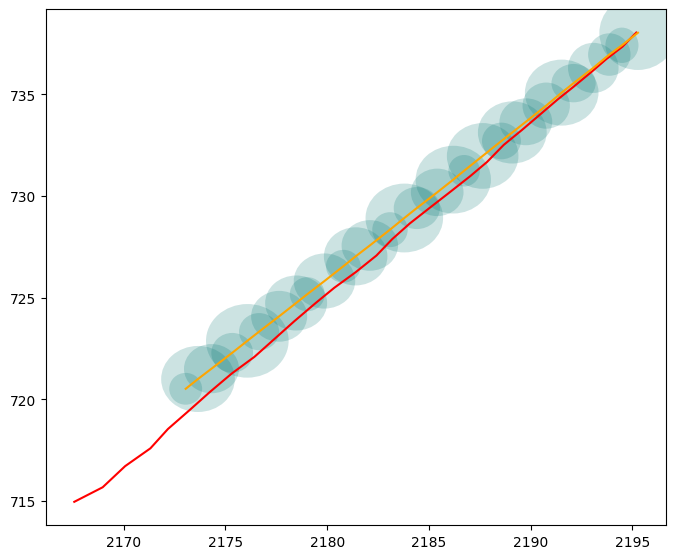

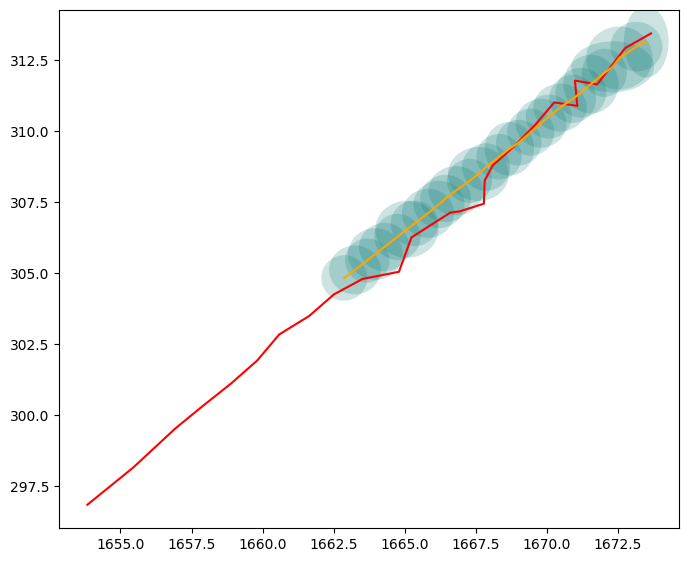

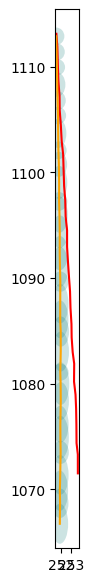

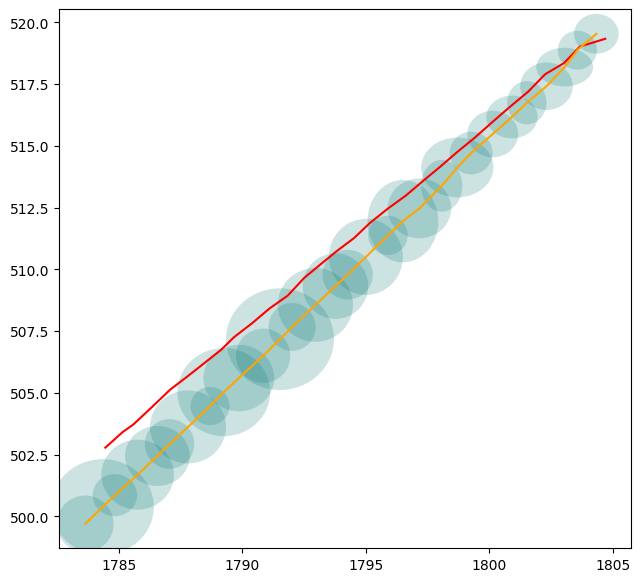

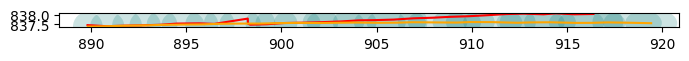

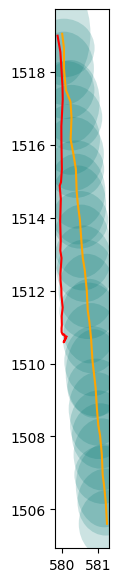

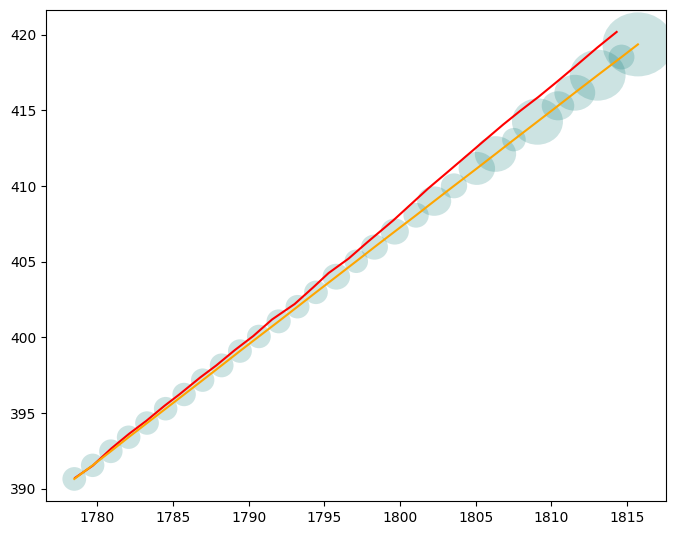

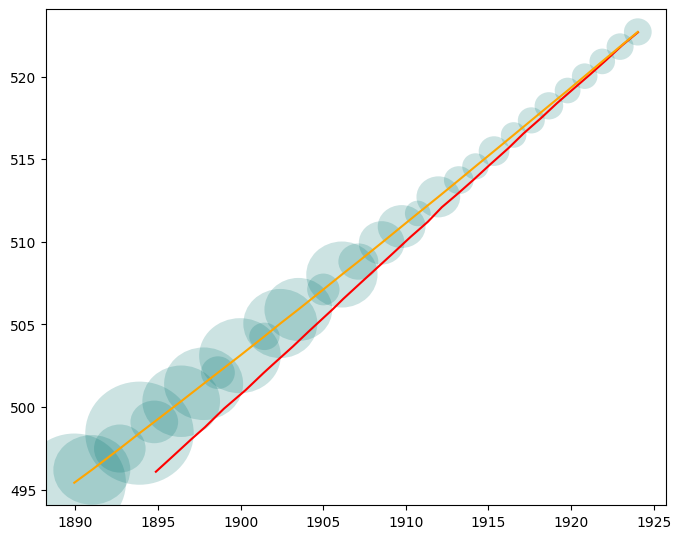

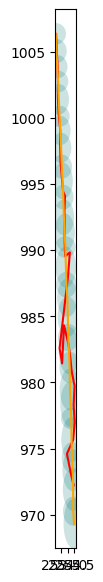

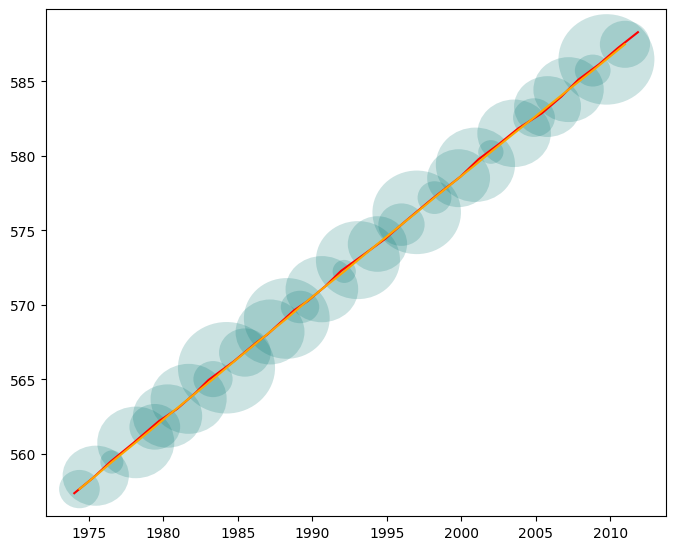

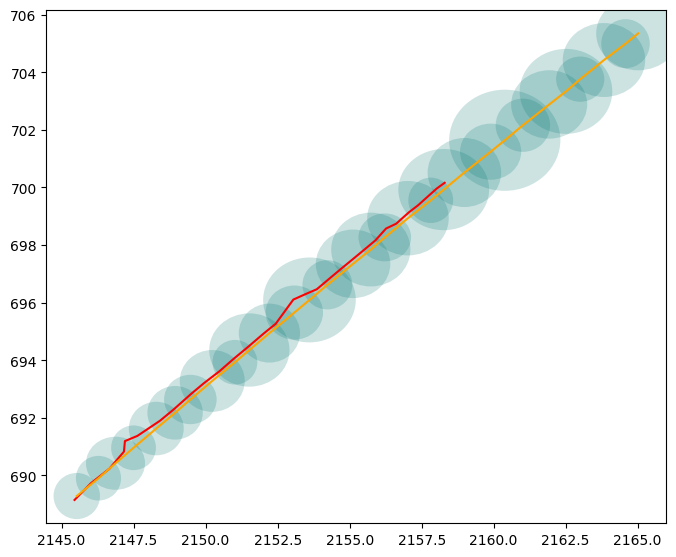

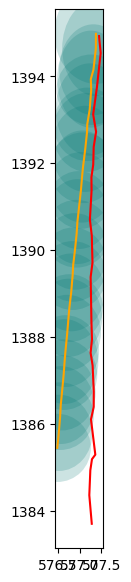

In [122]:
for k in prediction_gt.keys():
    plot_id(k)

In [69]:
def construct_df(pos, sig, track_id, agent_id, city):
    obj_type = np.array(['OTHERS'] * len(pos))
    track_id = track_id.squeeze()
    agent_id = agent_id.squeeze()
    obj_type[track_id == agent_id] = 'AGENT'
    df = pd.DataFrame(data = {'TRACK_ID': track_id.tolist(), 
                              'X': pos[:,0], 
                              'Y': pos[:,1], 
                              'sig0': sig[:,0,0],
                              'sig1': sig[:,0,1],
                              'sig2': sig[:,1,0],
                              'sig3': sig[:,1,1],
                              'OBJECT_TYPE': obj_type, 
                              'CITY_NAME': city})
    return df

In [273]:
def equi_pred(sample, model_equi):
    device='cpu'
    batch_size = 1
    
    data = process_batch(sample, device)
    sample['lane_mask'] = [np.array([0])] * batch_size
    data['lane'], data['lane_norm'] = torch.zeros(batch_size, 1, 2, device=device), torch.zeros(batch_size, 1, 2, device=device)
    data['lane_mask'] = torch.ones(batch_size, 1, 1, device=device)

    lane = data['lane']
    lane_normals = data['lane_norm']
    agent_id = data['agent_id']
    city = data['city']
    scenes = data['scene_idx'].tolist()

    mask = data['car_mask'][0].numpy().astype(bool).squeeze(-1)

    zeros = torch.zeros(sum(mask), 2, 2)
    prediction0 = construct_df(data['pos_2s'][0][mask,0], zeros, data['track_id0'][0][mask], data['agent_id'][0], data['city'][0])
    for i in range(1,18):
        prediction0 = prediction0.append(construct_df(data['pos_2s'][0][mask,i], zeros, data['track_id0'][0][mask], data['agent_id'][0], data['city'][0]))
    prediction0 = prediction0.append(construct_df(data['pos0'][0][mask], zeros, data['track_id0'][0][mask], data['agent_id'][0], data['city'][0]))

    inputs = ([
    data['pos_2s'], data['vel_2s'], 
    data['pos0'], data['vel0'], 
    data['accel'], data['sigmas'],
    data['lane'], data['lane_norm'], 
    data['car_mask'], data['lane_mask']
    ])
    m0 = torch.zeros((batch_size, 60, 2, 2), device=device)

    with torch.no_grad():
        pr_pos1, pr_vel1, pr_m1, states = model_equi(inputs)

        prediction0 = prediction0.append(construct_df(pr_pos1.numpy()[0,mask],pr_m1, data['track_id0'][0][mask], data['agent_id'][0], data['city'][0]))

        pos0, vel0 = data['pos0'], data['vel0']
        for i in range(29):
            pos_enc = torch.unsqueeze(pos0, 2)
            vel_enc = torch.unsqueeze(vel0, 2)
            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'],
                      torch.cat([m0, pr_m1], dim=-2), 
                      data['lane'],
                      data['lane_norm'], data['car_mask'], data['lane_mask'])

            pos0, vel0, m0 = pr_pos1, pr_vel1, pr_m1

            pr_pos1, pr_vel1, pr_m1, states = model_equi(inputs, states)
            prediction0 = prediction0.append(construct_df(pr_pos1.cpu().numpy()[0,mask], pr_m1, data['track_id0'][0][mask], data['agent_id'][0], data['city'][0]))
            # print('DONE')
    return prediction0

In [62]:
for data_true in val_dataset:
    if data_true['scene_idx'][0] == 6599:
        break
    else:
        pass
data_true['scene_idx'][0]

9918

In [78]:
prediction = equi_pred(data_true,trained_model )


NameError: name 'visualize_trajectory' is not defined

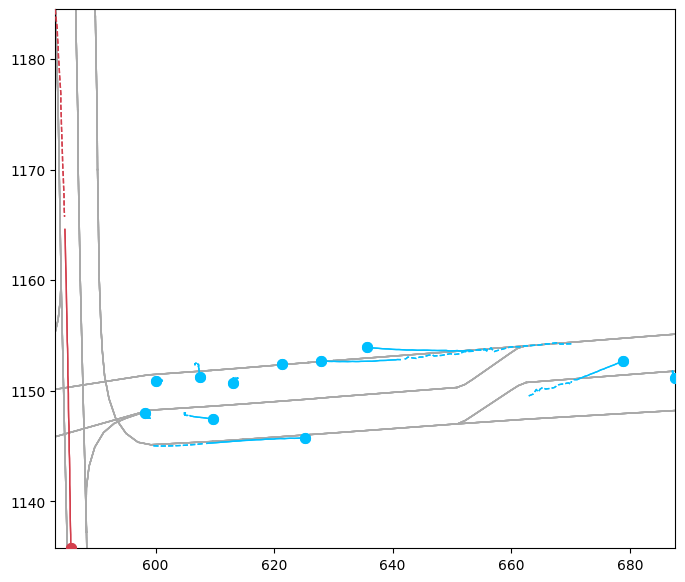

In [109]:
visualize_trajectory(prediction, show=True)

In [289]:
def visualize_prediction(
    pos, track_id, agent_id, city_name, frame_id, lane_centerlines = None, show: bool = True, smoothen: bool = False
) -> None:
    lane_centerlines = a(afl[frame_id].seq_df, city_name) if lane_centerlines is None else lane_centerlines
    plt.figure(0, figsize=(8, 7))
    x_min = min(pos[:, 0])
    x_max = max(pos[:, 0])
    y_min = min(pos[:, 1])
    y_max = max(pos[:, 1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")
    plt.xlabel("Map X")
    plt.ylabel("Map Y")
    color_dict = {"AGENT": "#d33e4c", "OTHERS": "#13d4f2", "AV": "#007672"}
    object_type_tracker: Dict[int, int] = defaultdict(int)
    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]
        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values
        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]
        plt.plot(
            cor_x,
            cor_y,
            "-",
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        final_x = cor_x[-1]
        final_y = cor_y[-1]
        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7
        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )
        object_type_tracker[object_type] += 1
    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")
    plt.axis("off")

In [38]:
pred

[tensor([[[ 589.4445, 1381.8385]]]),
 tensor([[[ 589.6328, 1381.6088]]]),
 tensor([[[ 589.3992, 1380.2305]]]),
 tensor([[[ 588.9202, 1380.0366]]]),
 tensor([[[ 579.9214, 1367.5590]]]),
 tensor([[[ 584.3655, 1377.3729]]]),
 tensor([[[ 596.6658, 1271.8363]]]),
 tensor([[[ 640.7068, 1356.7920]]]),
 tensor([[[597.8172, 894.6785]]]),
 tensor([[[ 828.4139, 1853.6736]]]),
 tensor([[[  226.0106, -1018.5403]]]),
 tensor([[[1994.9950, 6174.8740]]]),
 tensor([[[ -2903.6455, -13136.2568]]]),
 tensor([[[10917.8076, 36676.0664]]]),
 tensor([[[-29450.9258, -93312.3594]]]),
 tensor([[[ 86699.4688, 243709.0000]]]),
 tensor([[[-246646.8906, -628298.2500]]]),
 tensor([[[ 739073.2500, 1645480.5000]]]),
 tensor([[[-2385644.5000, -4320317.0000]]]),
 tensor([[[ 7071482., 11239530.]]]),
 tensor([[[-20403056., -27931576.]]])]

In [39]:
gt

[tensor([[[ 587.6106, 1381.2997]]]),
 tensor([[[ 587.6106, 1381.2997]]]),
 tensor([[[ 586.9632, 1380.9113]]]),
 tensor([[[ 586.6739, 1380.7225]]]),
 tensor([[[ 586.3462, 1380.4492]]]),
 tensor([[[ 585.7589, 1379.9354]]]),
 tensor([[[ 585.4659, 1379.6121]]]),
 tensor([[[ 584.9191, 1379.0210]]]),
 tensor([[[ 584.6808, 1378.6652]]]),
 tensor([[[ 584.3546, 1378.2303]]]),
 tensor([[[ 583.8191, 1377.5601]]]),
 tensor([[[ 583.6369, 1377.1196]]]),
 tensor([[[ 583.3925, 1376.6952]]]),
 tensor([[[ 582.9846, 1375.8479]]]),
 tensor([[[ 582.7881, 1375.3280]]]),
 tensor([[[ 582.6030, 1374.8840]]]),
 tensor([[[ 582.4222, 1374.3217]]]),
 tensor([[[ 582.2029, 1373.8376]]]),
 tensor([[[ 582.0811, 1373.3918]]]),
 tensor([[[ 581.8999, 1372.7820]]]),
 tensor([[[ 581.7318, 1372.3556]]])]

In [31]:
prediction_gt.keys()

dict_keys([])

In [98]:
dataset_path = '../../argoverse_data/rose'
train_path = os.path.join(dataset_path, 'train') #, 'lane_data'
train_dataset = read_pkl_data(train_path, batch_size=1, shuffle=False, repeat=False)

In [217]:
dataset_path = '../../argoverse_data/argoverse_one'
train_path = os.path.join(dataset_path, 'train') #, 'lane_data'
train_dataset = read_pkl_data(train_path, batch_size=1, shuffle=False, repeat=False)

In [218]:
datas = iter(train_dataset)

In [219]:
for s in datas:
    print(s)
    pin=s['p_in']
    pout=s['p_out']

{'city': ['MIA'], 'lane': [array([[ 567.71533203, 1535.64624023],
       [ 571.32281494, 1535.35205078],
       [ 574.93920898, 1535.32275391],
       ...,
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ]])], 'lane_norm': [array([[ 3.60866714, -0.28309062],
       [ 3.607445  , -0.29420608],
       [ 3.61640382, -0.02925371],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])], 'scene_idx': [30587], 'agent_id': ['00000000-0000-0000-0000-000000003326'], 'car_mask': [array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
      

In [220]:
p_in = np.array(pin)[:,0,:,:]
p_out = np.array(pout)[:,0,:,:]


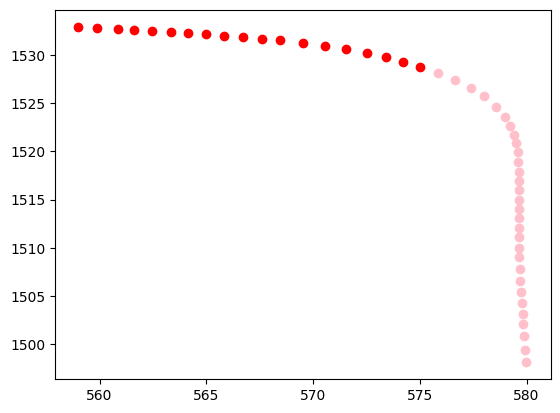

In [222]:
plt.scatter(p_in[...,0], p_in[...,1],c='r')
plt.scatter(p_out[...,0], p_out[...,1],c='pink')
plt.show()

In [155]:
with open('../../argoverse_data/results/ecco_one_predictions.pickle','rb') as f:
    pred = pickle.load(f)

In [156]:
pred

{30587: (tensor([[ 5.6221e+02,  1.5326e+03, -1.2198e+00, -2.0416e-01,  3.8867e-01,
           -9.0358e-01],
          [ 5.6359e+02,  1.5323e+03, -1.2293e+00, -1.6913e-01,  3.5973e-01,
           -9.2603e-01],
          [ 5.6500e+02,  1.5320e+03, -1.2390e+00, -1.3040e-01,  3.3523e-01,
           -9.4112e-01],
          [ 5.6643e+02,  1.5317e+03, -1.1570e+00, -8.7176e-02,  2.7045e-01,
           -8.9025e-01],
          [ 5.6788e+02,  1.5314e+03, -1.1176e+00, -4.8495e-02,  2.3440e-01,
           -8.7140e-01],
          [ 5.6935e+02,  1.5311e+03, -1.0632e+00, -4.0328e-03,  1.8775e-01,
           -8.4672e-01]]),
  tensor([[ 562.1722, 1532.5005],
          [ 563.3536, 1532.3491],
          [ 564.8810, 1532.0056],
          [ 566.1856, 1531.7959],
          [ 567.6631, 1531.4575],
          [ 569.8911, 1531.0394]]))}

In [199]:
pred_t = pred[30587][0].numpy()
gt =  pred[30587][1].numpy()

In [201]:
pred_t[0]

array([ 5.6220844e+02,  1.5325548e+03, -1.2198370e+00, -2.0415717e-01,
        3.8866821e-01, -9.0358025e-01], dtype=float32)

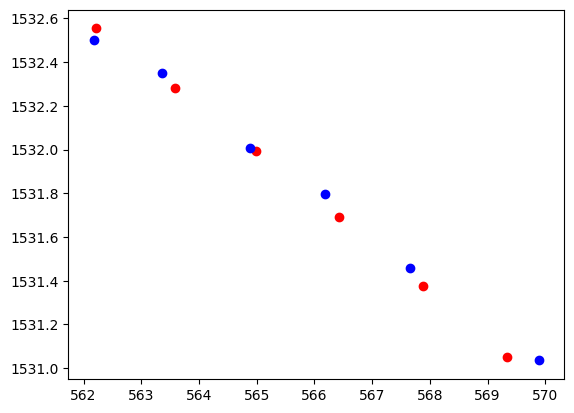

In [202]:
plt.scatter(pred_t[:,0], pred_t[:,1], c='r')#,2)
plt.scatter(gt[:,0], gt[:,1],c='b')#,2)

plt.show()

In [223]:
test = np.array([[1,2],[3,4],[5,6]])
oje = np.array([[5,4],[3,2],[1,0]])

In [228]:
rmse = np.sqrt(np.mean((test-oje)**2))
rmse

3.559026084010437

In [229]:
ade = np.mean(np.sqrt((test[:,0] - oje[:,0])**2 + (test[:,1] - oje[:,1])**2))

4.561079501975853

In [128]:

new_all_pos = []
lanes = []
count = 0
for s in datas:
    pos = s['p_in']
    la = s['lane']
    new_all_pos.append(pos)
    lanes.append(la)

In [101]:

new_all_pos = []
lanes = []
count = 0
for s in datas:
    pos = s['p_in']
    la = s['lane']
    new_all_pos.append(pos)
    lanes.append(la)

    count +=1
    if count >= 300:
        break

In [129]:
all_pos = np.array(new_all_pos)
laness = np.array(lanes)

In [124]:
all_pos = np.concatenate((all_pos,new_all_pos))

In [131]:
all_pos.shape

(0,)

In [130]:
xs = all_pos[...,0].flatten()
ys = all_pos[...,1].flatten()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [111]:
lx = laness[...,0].flatten()
ly = laness[...,1].flatten()

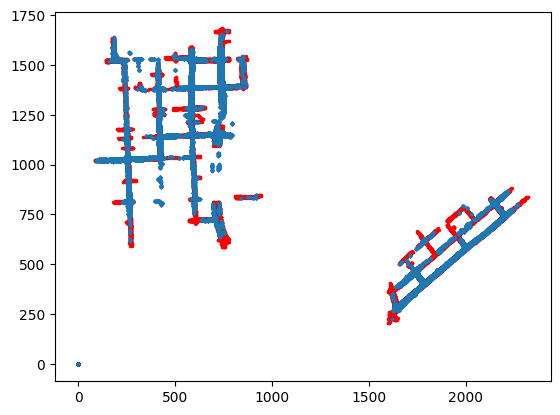

In [108]:
plt.scatter(lx,ly , 2, c='r')
plt.scatter(xs, ys,2)
plt.show()

In [112]:
smallx = xs[xs<1100]
smally = ys[xs<1100]

smalllx= lx[lx<1100]
smallly= ly[lx<1100]


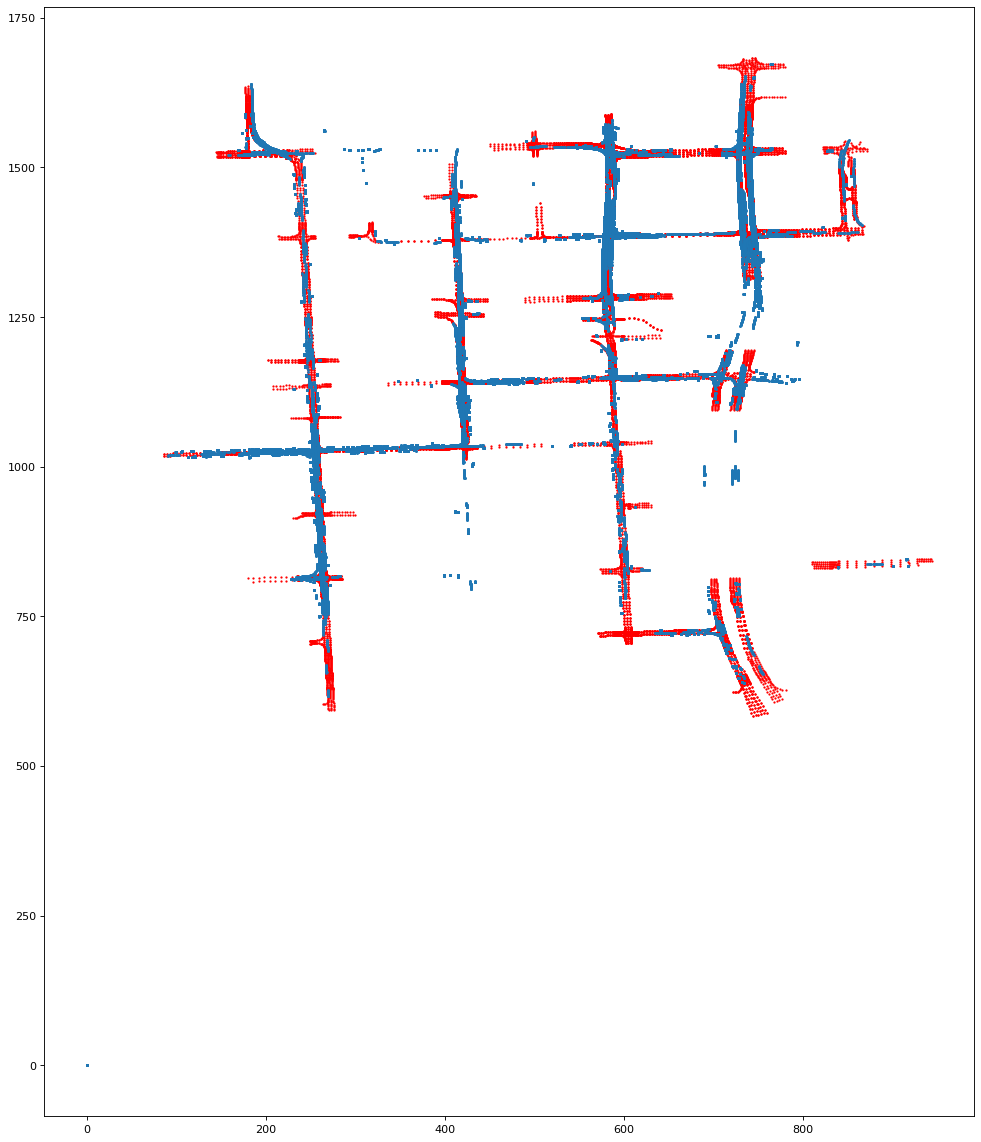

In [118]:
from matplotlib.pyplot import figure

figure(figsize=(15, 18), dpi=80)

plt.scatter(smalllx, smallly, 1, c='r')

plt.scatter(smallx, smally, 2)

plt.show()

In [ ]:
def plot_id(key):
    pred = prediction_gt[key][0]
    gt = prediction_gt[key][1].numpy()
    cov = get_coverage(pred[:,:2], prediction_gt[key][1],pred[:,3:].reshape(30,2,2))
    print('cov', cov)
    
    M = torch.tanh(pred[:,3:].reshape(30,2,2))
    sigma = calc_sigma(M)
    pred = pred.numpy()
    new_M = sigma.numpy() 

    sig_x = np.sqrt(new_M[:,0,0])
    sig_y = np.sqrt(new_M[:,1,1])
    rho = new_M[:,0,1]/(sig_x*sig_y)

    fig = plt.figure(0, figsize=(8, 7))

    ax = fig.add_subplot(111, aspect='equal')

    plt.plot(gt[:,0],gt[:,1], c='r')
    plt.plot(pred[:,0],pred[:,1], c='orange')

    scale = 2*np.sqrt(5.991)
    ells = [Ellipse(xy=gaussian[:2], 
                    width=scale*sig_x[i], 
                    height=scale*sig_y[i], 
                    angle=np.arctan(rho[i]))
            for i, gaussian in enumerate(pred)]
    #plt.xlim(410, 420)
    for e in ells:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.2)
        e.set_facecolor("#007672")
    
    plt.show()